<a href="https://colab.research.google.com/github/Clarkdrengen/PML_2023/blob/main/pytorch-mnist-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 214882656.41it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110525268.09it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69512733.78it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14586928.61it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
image_size = 784
#h_dim = 400
#z_dim = 20
num_epochs = 10#50
x_dim=784, 
h_dim1= 512, 
h_dim2=256, 
z_dim=2
#learning_rate = 1e-3


In [4]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
#vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=2)
vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=z_dim)
if torch.cuda.is_available():
    vae.cuda()

In [5]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [6]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [7]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
          data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [8]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
              data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [9]:
device

device(type='cuda')

In [10]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.514219
Train Epoch: 1 [10000/60000 (17%)]	Loss: 184.934023
Train Epoch: 1 [20000/60000 (33%)]	Loss: 181.192988
Train Epoch: 1 [30000/60000 (50%)]	Loss: 172.980918
Train Epoch: 1 [40000/60000 (67%)]	Loss: 171.309590
Train Epoch: 1 [50000/60000 (83%)]	Loss: 163.885645
====> Epoch: 1 Average loss: 179.5235
====> Test set loss: 162.3471
Train Epoch: 2 [0/60000 (0%)]	Loss: 154.259033
Train Epoch: 2 [10000/60000 (17%)]	Loss: 154.631699
Train Epoch: 2 [20000/60000 (33%)]	Loss: 168.192773
Train Epoch: 2 [30000/60000 (50%)]	Loss: 155.241777
Train Epoch: 2 [40000/60000 (67%)]	Loss: 154.806064
Train Epoch: 2 [50000/60000 (83%)]	Loss: 147.451934
====> Epoch: 2 Average loss: 157.9057
====> Test set loss: 155.2329
Train Epoch: 3 [0/60000 (0%)]	Loss: 156.103516
Train Epoch: 3 [10000/60000 (17%)]	Loss: 153.689844
Train Epoch: 3 [20000/60000 (33%)]	Loss: 154.592080
Train Epoch: 3 [30000/60000 (50%)]	Loss: 155.289639
Train Epoch: 3 [40000/60000 (67%)]	Loss: 146.10

In [11]:
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<class 'torch.Tensor'>
torch.Size([64, 784])


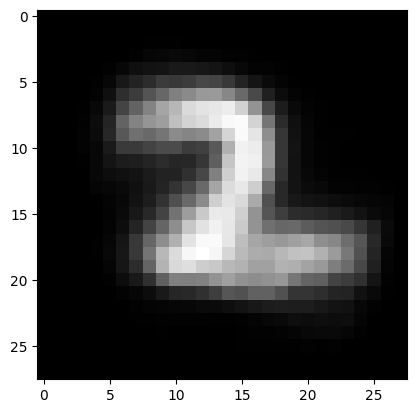

In [12]:
with torch.no_grad():
    #z = torch.randn(64, 2).cuda()
    z = torch.randn(64, 2).to(device)
    #sample = vae.decoder(z).cuda()
    sample = vae.decoder(z).to(device)
    print(sample.__class__)
    print(sample.size())

    sample = sample.cpu() # use .cpu().numpy() to move off the GPU ## NOTE: moving to numpy is redundant and unhelpful 
    image = sample[0].reshape(28,28)    # shows the first of 64 randimly generated pictures
    plt.imshow(image, cmap="gray")
  

    #plt.imshow(sample[0].reshape(28,28), cmap="gray")
    #save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

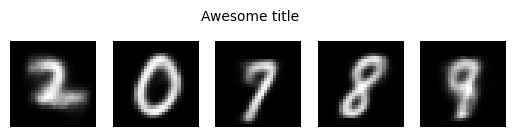

In [13]:
#plt.imshow(sample[0].reshape(28,28).cpu().numpy().reshape(28,28), cmap="gray")

images = sample[:5].reshape((-1, 28, 28))  # se

fig, axes = plt.subplots(nrows=1, ncols=5)  # create a 4x4 grid of subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')  # display image on the current subplot

[axi.set_axis_off() for axi in axes.ravel()] # kill axes h/t https://stackoverflow.com/questions/25862026/turn-off-axes-in-subplots
fig.suptitle('Awesome title', fontsize=10, y=.65) # awesome title h/t https://www.geeksforgeeks.org/how-to-set-a-single-main-title-for-all-the-subplots-in-matplotlib/
plt.show()

In [24]:
# store ground truth test images
test_images_ground_truth, _ = next(iter(test_loader))

torch.Size([12, 1, 28, 28])


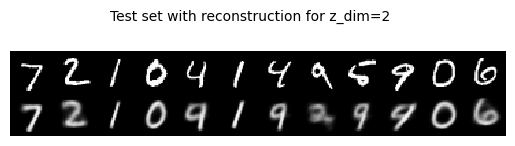

In [25]:
## now create an image of estimated images and ground truth
# h/t https://stackoverflow.com/questions/66667949/pytorch-mnist-autoencoder-to-learn-10-digit-classification

## run first five training images through the encoder
### from https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.suptitle('Test set with reconstruction for z_dim=2', fontsize=10, y=.67)
    plt.axis('off')
    plt.show()

def plot_reconstruction(vae, n=12):
    
    #x,_ = next(iter(test_loader))
    x = test_images_ground_truth
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = vae(x.view(-1, image_size)) 
    except:
        out, _, _ = vae(x.view(-1, image_size))
    print(x.size()) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=0)
    out_grid = torchvision.utils.make_grid(x_concat, nrow=12)#.cpu().data
    show(out_grid)

plot_reconstruction(vae)

##Now adjust model to include convolutions

In [26]:
import torch.nn.functional as F

class ConvolutionalVAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(ConvolutionalVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(x_dim, h_dim1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(h_dim1, h_dim2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        
        self.fc31 = nn.Linear(h_dim2 * 7 * 7, z_dim)
        self.fc32 = nn.Linear(h_dim2 * 7 * 7, z_dim)
        
        # Decoder
        self.fc4 = nn.Linear(z_dim, h_dim2 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(h_dim2, h_dim1, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim1, x_dim, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        return self.fc31(x), self.fc32(x) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu # return z sample
        
    def decode(self, z):
        h = F.relu(self.fc4(z))
        h = h.view(-1, h_dim2, 7, 7)
        return self.decoder(h)
    
    def forward(self, x):
        x = x.view(-1, x_dim, 28, 28) # Reshape the input if necessary
        mu, log_var = self.encode(x)
        z = self.sampling(mu, log_var)
        return self.decode(z), mu, log_var


# build model
#vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=2)
vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=z_dim)
if torch.cuda.is_available():
    vae.cuda()

In [1]:
image_channels = 1
conv_vae = ConvolutionalVAE(x_dim=image_channels, h_dim1=32, h_dim2=64, z_dim=2)
if torch.cuda.is_available():
    conv_vae.cuda()

NameError: ignored

In [ ]:
def train(epoch):
    conv_vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
          data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = conv_vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [35]:
def test():
    conv_vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
              data = data.cuda()
            recon, mu, log_var = conv_vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [36]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

TypeError: ignored